In [31]:
from os.path import exists
import requests
from typing import *

import math
import numpy as np
import scipy as sp
import scipy.stats   # statistics package
import pandas as pd
from tqdm.notebook import trange, tqdm

# Homework 3: Optimization and Regression, Due October 14, 2022

1. Answer each question.
2. Feel free to leave in testing code and other visualization code.

## Problem 1 (30 pts): A Fully Connected and Single-Layer Neural Network

Suppose we are fitting a regression model to a dataset $(x_i, y_i)_{1 \leq i \leq N}$
\begin{align*}
p(y^i|x^i; A, \mu) & = \mathcal{N}(f(Ax^i + \mu), 1) \\
p(y |x; A, \mu) & = \prod_{i=1}^N p(y^i|x^i; A, \mu)
\end{align*}
where
1. the inputs $x^i \in \mathbb{R}^d$ are d-D vectors
2. $A$ is a $1 \times d$ matrix of weights
$$
A = \begin{pmatrix}
a_{11} & \dots & a_{1d} 
\end{pmatrix}
$$
3. $f: \mathbb{R} \rightarrow \mathbb{R}$ is some function
4. $x$ is a $Nxd$ matrix where row $i$ contains $x^i$
$$
x = \begin{pmatrix}
- & x^1 & -\\
\vdots & \vdots & \vdots\\
- & x^N & -
\end{pmatrix}
$$
5. $y$ is a vector of values to regress against
$$
y = \begin{pmatrix}
y^1 \\
\vdots \\
y^N
\end{pmatrix}
$$
6. $\mu \in \mathbb{R}$ is an offset

### Problem 1a (10 pts)

Implement the conditional density:
$$
p(y |x; A, \mu) = \prod_{i=1}^N p(y^i|x^i; A, \mu)
$$

In [6]:
def model1_density(f: Callable[[float], float],
                   A: np.ndarray,
                   mu: float) -> Callable[[np.ndarray, np.ndarray], float]:
    # Inputs:
    #     f is some function
    #     A is a 1xd matrix
    #     mu is a float indicating the constant offset
    #
    # Outputs:
    #     Return the density as a function of the dataset x and y
    
#     def construct_distribution(theta, x,scale):
#         x = np.concatenate([x, np.ones((3, 1))], axis=1)
#         normals = [
#             sp.stats.norm(loc=np.dot(theta, x[0]), scale=scale),
#             sp.stats.norm(loc=np.dot(theta, x[1]), scale=scale),
#             sp.stats.norm(loc=np.dot(theta,x[2]), scale=scale)
#         ]
#         return normals
# (𝑓(𝐴𝑥𝑖+𝜇),1)
    
    def density(x: np.ndarray, y: np.ndarray) -> float:
        # Inputs:
        #     x is a Nxd matrix where each row is a datapoint
        #
        # Outputs:
        #     y is a length n vector to evaluate the density on
        fx = f(np.dot(A,x) + mu)
        normals = []
        for i in range(x.shape[0]):
            normals.append(sp.stats.norm(loc=fx[i],scale=1))
        res = 1
        for i,norm in enumerate(normals):
            res *= norm.pdf(y[i])
        return res
    return density

In [7]:
def f(x):
    return x**2

A = np.array([2.0, 0.5])

mu = 3.7
x = np.array([[0.57,0.21],[0.22,0.83]])
y = np.array([0.3,0.1])
print(np.dot(x,A))

[1.245 0.855]


In [8]:
densityFunction = model1_density(f,A,mu)
densityFunction(x,y)

1.1213937137482755e-219

### Problem 1b (10 pts)

Derive and implement
$$
\frac{\partial}{\partial A} p(y |x; A, \mu)
$$
and
$$
\frac{\partial}{\partial \mu} p(y |x; A, \mu) \,.
$$

In [9]:
def grad_f(x):
    return 2*x

In [40]:
def grad_A(f: Callable[[float], float],
           grad_f: Callable[[float], float],
           A: np.ndarray,
           mu: float,
           x: np.ndarray,
           y: np.ndarray) -> np.ndarray:
    # Inputs:
    #     f is some function
    #     grad_f is the gradient of f
    #     A is a 1xd matrix
    #     mu is a float indicating the constant offset
    #.    x is a nxd matrix of inputs
    #     y is a length n vector of regression outputs
    #
    # (𝑓(𝐴𝑥𝑖+𝜇),1)
    # Outputs:
    #     Return the gradient of the conditional density w.r.t. the matrix A, which should be a 1xd matrix.
    
    # y = 𝑓(𝐴𝑥𝑖+𝜇)
    # dy/dA = f(xi)
    return (x * (x - f(A*x + mu))*(math.e**-(((x-f(A*x + mu))**2)/(2)))*grad_f(A*x + mu))/(math.sqrt(2*math.pi))
    
    


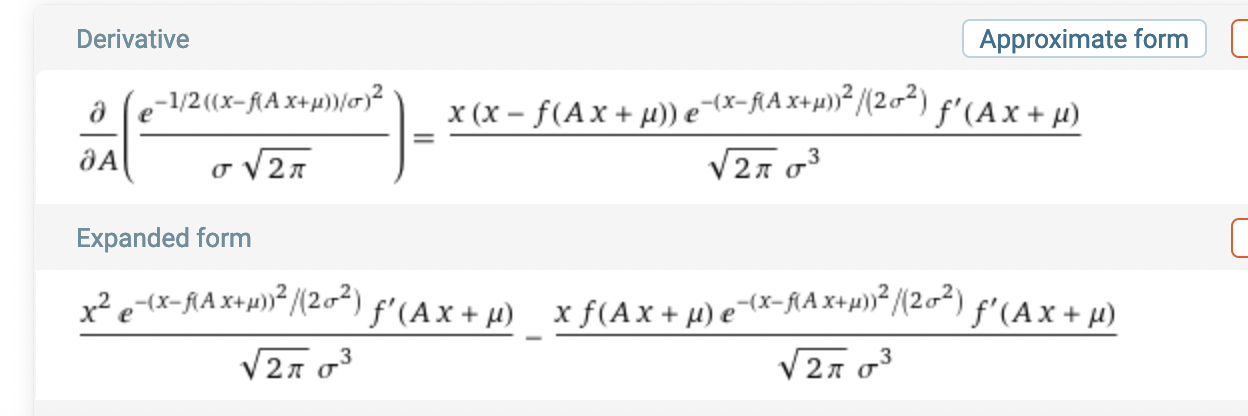

In [41]:
grad_A(f, grad_f, A, mu, x, y)

array([[-1.85615167e-112, -5.65971366e-044],
       [-8.44093514e-062, -2.15284426e-055]])

In [48]:
def grad_mu(f: Callable[[float], float],
            grad_f: Callable[[float], float],
            A: np.ndarray,
            mu: float,
            x: np.ndarray,
            y: np.ndarray) -> float:
    # Inputs:
    #     f is some function
    #     grad_f is the gradient of f
    #     A is a 1xd matrix
    #     mu is a float indicating the constant offset
    #.    x is a nxd matrix of inputs
    #     y is a length n vector of regression outputs
    #
    # Outputs:
    #     Return the gradient of the conditional density w.r.t. the offset mu, which should be a float.
     # y = 𝑓(𝐴𝑥𝑖+𝜇)
    # dy/dA = f(xi)
    
    
    
    return ((x - f(A*x + mu))*(math.e**-(((x-f(A*x + mu))**2)/(2)))*(A*grad_f(A*x + mu) - 1))/(math.sqrt(2*math.pi))


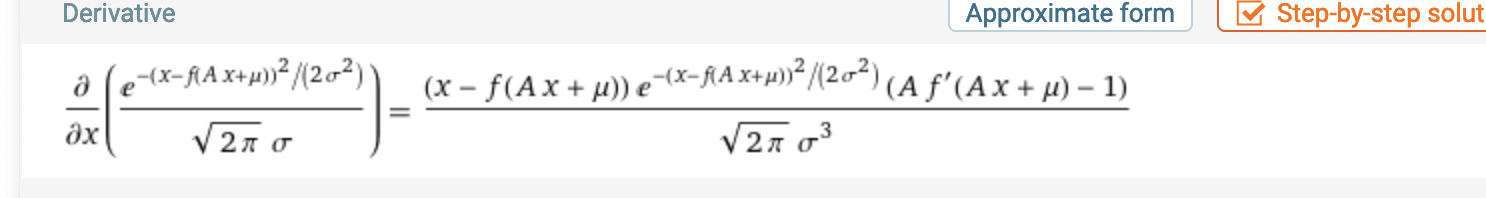

In [49]:
grad_mu(f, grad_f, A, mu, x, y)

array([[-6.17640725e-112, -9.93398212e-044],
       [-7.21019712e-061, -9.81731525e-056]])

### Problem 1c (10 pts)

Write a function that solves for the weights by finding the approximate minimum of the conditional density, i.e., solve
$$
\operatorname{argmin}_{A, \mu} -p(y | x; A, \mu)
$$
with **stochastic gradient descent**. Hint: you may want to use the negative log-likelihood trick.

In [5]:
def solve_for_weights(f: Callable[[float], float],
                      grad_f: Callable[[float], float],
                      A: np.ndarray,
                      mu: float,
                      initial_A: np.ndarray,
                      initial_mu: np.ndarray,
                      step_size: float,
                      batch_size: int) -> Tuple[np.ndarray, float]:
    # Inputs:
    #     f is some function
    #     grad_f is the gradient of f
    #     A is a 1xd matrix
    #     mu is a float indicating the constant offset
    #     initial_A is a 1xd matrix containing the initial guess of A for stochastic gradient descent
    #     initial_mu is a float containing the initial guess of mu for stochastic gradient descent
    #     step_size is a the step size of stochastic gradient descent
    #     batch_size is the batch size of stochastic gradient descent    
    #
    # Outputs:
    #     Return the density as a function of the dataset x and y
    best_A = np.zeros(A.shape)
    best_mu = 0.
    
    # TODO: fill me in
    
    return best_A, best_mu

## Problem 2 (50 pts): A Fully Connected and Two-Layer Neural Network

Suppose we are fitting a regression model to a dataset $(x_i, y_i)_{1 \leq i \leq N}$
\begin{align*}
p(y^i|x^i; A_1, \mu_1, A_2, \mu_2) & = \mathcal{N}(f(A_2 f(A_1x^i + \mu_1) + \mu_2), 1) \\
p(y |x; A_1, \mu_1, A_2, \mu_2) & = \prod_{i=1}^N p(y^i|x^i; A_1, \mu_1, A_2, \mu_2)
\end{align*}
where
1. the inputs $x^i \in \mathbb{R}^d$ are d-D vectors
2. $A_1$ is a $m \times d$ matrix of weights and $A_2$ is a $1 \times m$ matrix of weights.
$$
A = \begin{pmatrix}
a_{11} & \dots & a_{1d} 
\end{pmatrix}
$$
3. $\mu_1 \in \mathbb{R}^m$ is a vector of weights and $\mu_2 \in \mathbb{R}$ is a weight.
4. $f: \mathbb{R} \rightarrow \mathbb{R}$ is some function
5. $x$ is a $Nxd$ matrix where row $i$ contains $x^i$
$$
x = \begin{pmatrix}
- & x^1 & -\\
\vdots & \vdots & \vdots\\
- & x^N & -
\end{pmatrix}
$$
6. $y$ is a vector of values to regress against
$$
y = \begin{pmatrix}
y^1 \\
\vdots \\
y^N
\end{pmatrix}
$$

### Problem 2a (10 pts)

Implement the conditional density:
$$
p(y |x; A_1, \mu_1, A_2, \mu_2) = \prod_{i=1}^N p(y^i|x^i; A_1, \mu_1, A_2, \mu_2)
$$

In [6]:
def model2_density(f: Callable[[float], float],
                   A1: np.ndarray,
                   mu1: float,
                   A2: np.ndarray,
                   mu2: float) -> Callable[[np.ndarray, np.ndarray], float]:
    # Inputs:
    #     f is some function
    #     A1 is a mxd matrix
    #     mu1 is a length m vector
    #     A2 is a 1xm matrix
    #     mu2 is a float indicating the constant offset
    #
    # Outputs:
    #     Return the density as a function of the dataset x and y
    def density(x: np.ndarray, y: np.ndarray) -> float:
        # Inputs:
        #     x is a Nxd matrix where each row is a datapoint
        #
        # Outputs:
        #     y is a length n vector to evaluate the density on
        pass
    
    return density

### Problem 2b (15 pts)

Derive and implement
$$
\frac{\partial}{\partial A_1} p(y |x; A_1, \mu_1, A_2, \mu_2)
$$
and
$$
\frac{\partial}{\partial \mu_1} p(y |x; A_1, \mu_1, A_2, \mu_2) \,.
$$

In [7]:
def grad_A1(f: Callable[[float], float],
            grad_f: Callable[[float], float],
            A1: np.ndarray,
            mu1: float,
            A2: np.ndarray,
            mu2: float,
            x: np.ndarray,
            y: np.ndarray) -> np.ndarray:
    # Inputs:
    #     f is some function
    #     grad_f is the gradient of f
    #     A1 is a mxd matrix of weights
    #     mu1 is a vector of constant offsets
    #     A2 is a 1xm matrix of weights
    #     mu2 is a float that is a constant offset
    #     x is a nxd matrix of inputs
    #     y is a length n vector of regression outputs
    #
    # Outputs:
    #     Return the gradient of the conditional density w.r.t. the matrix A, which should be a 1xd matrix.
    pass

In [8]:
def grad_mu1(f: Callable[[float], float],
            grad_f: Callable[[float], float],
            A1: np.ndarray,
            mu1: float,
            A2: np.ndarray,
            mu2: float,
            x: np.ndarray,
            y: np.ndarray) -> np.ndarray:
    # Inputs:
    #     f is some function
    #     grad_f is the gradient of f
    #     A1 is a mxd matrix of weights
    #     mu1 is a vector of constant offsets
    #     A2 is a 1xm matrix of weights
    #     mu2 is a float that is a constant offset
    #     x is a nxd matrix of inputs
    #     y is a length n vector of regression outputs
    #
    # Outputs:
    #     Return the gradient of the conditional density w.r.t. the matrix A, which should be a 1xd matrix.
    pass

### Problem 2c (15 pts)

Derive and implement
$$
\frac{\partial}{\partial A_2} p(y |x; A_1, \mu_1, A_2, \mu_2)
$$
and
$$
\frac{\partial}{\partial \mu_2} p(y |x; A_1, \mu_1, A_2, \mu_2) \,.
$$

In [9]:
def grad_A2(f: Callable[[float], float],
            grad_f: Callable[[float], float],
            A1: np.ndarray,
            mu1: float,
            A2: np.ndarray,
            mu2: float,
            x: np.ndarray,
            y: np.ndarray) -> np.ndarray:
    # Inputs:
    #     f is some function
    #     grad_f is the gradient of f
    #     A1 is a mxd matrix of weights
    #     mu1 is a vector of constant offsets
    #     A2 is a 1xm matrix of weights
    #     mu2 is a float that is a constant offset
    #     x is a nxd matrix of inputs
    #     y is a length n vector of regression outputs
    #
    # Outputs:
    #     Return the gradient of the conditional density w.r.t. the matrix A, which should be a 1xd matrix.
    pass

In [10]:
def grad_mu2(f: Callable[[float], float],
             grad_f: Callable[[float], float],
             A1: np.ndarray,
             mu1: float,
             A2: np.ndarray,
             mu2: float,
             x: np.ndarray,
             y: np.ndarray) -> float:
    # Inputs:
    #     f is some function
    #     grad_f is the gradient of f
    #     A1 is a mxd matrix of weights
    #     mu1 is a vector of constant offsets
    #     A2 is a 1xm matrix of weights
    #     mu2 is a float that is a constant offset
    #     x is a nxd matrix of inputs
    #     y is a length n vector of regression outputs
    #
    # Outputs:
    #     Return the gradient of the conditional density w.r.t. the matrix A, which should be a 1xd matrix.
    pass

### Problem 2d (10 pts)

Write a function that solves for the weights by finding the approximate minimum of the conditional density, i.e., solve
$$
\operatorname{argmin}_{A_1, \mu_1, A_2, \mu_2} -p(y | x; A_1, \mu_1, A_2, \mu_2)
$$
with **stochastic gradient descent**. Hint: you may want to use the negative log-likelihood trick.

In [11]:
def solve_for_weights(f: Callable[[float], float],
                      grad_f: Callable[[float], float],
                      A1: np.ndarray,
                      mu1: np.ndarray,
                      A2: np.ndarray,
                      mu2: float,
                      initial_A1: np.ndarray,
                      initial_mu1: np.ndarray,
                      initial_A2: np.ndarray,
                      initial_mu2: float,
                      step_size: float,
                      batch_size: int) -> Tuple[np.ndarray, float]:
    # Inputs:
    #     f is some function
    #     grad_f is the gradient of f
    #     A1 is a mxd matrix of weights
    #     mu1 is a vector of constant offsets
    #     A2 is a 1xm matrix of weights
    #     mu2 is a float that is a constant offset
    #     initial_A1 is a mxd matrix containing the initial guess of A1 for stochastic gradient descent
    #     initial_mu1 is a length d vector containing the initial guess of mu1 for stochastic gradient descent
    #     initial_A2 is a 1xm matrix containing the initial guess of A2 for stochastic gradient descent
    #     initial_mu2 is a float containing the initial guess of mu2 for stochastic gradient descent
    #     step_size is a the step size of stochastic gradient descent
    #     batch_size is the batch size of stochastic gradient descent    
    #
    # Outputs:
    #     Return the density as a function of the dataset x and y
    best_A = np.zeros(A.shape)
    best_mu = 0.
    
    # TODO: fill me in
    
    return best_A, best_mu

### Problem 3 (20 pts): Multi-output Regression

Suppose we are fitting a regression model to a dataset $(x_i, y_i)_{1 \leq i \leq N}$
\begin{align*}
p(y^i|x^i; A, \mu, \Sigma) & = \mathcal{N}(f(Ax^i + \mu), \Sigma) \\
p(y |x; A, \mu, \Sigma) & = \prod_{i=1}^N p(y^i|x^i; A, \mu, \Sigma)
\end{align*}
where
1. the inputs $x^i \in \mathbb{R}^d$ are d-D vectors
2. $A$ is a $2 \times d$ matrix of weights
$$
A = \begin{pmatrix}
a_{11} & \dots & a_{1d} \\
a_{21} & \dots & a_{2d}
\end{pmatrix}
$$
3. $f: \mathbb{R} \rightarrow \mathbb{R}$ is some function
4. $x$ is a $Nxd$ matrix where row $i$ contains $x^i$
$$
x = \begin{pmatrix}
- & x^1 & -\\
\vdots & \vdots & \vdots\\
- & x^N & -
\end{pmatrix}
$$
5. $y$ is a $Nx2$ matrix of values to regress against
$$
y = \begin{pmatrix}
y^1_1 & y^1_2\\
\vdots \\
y^N_1 & y^N_2\\
\end{pmatrix}
$$
6. $\Sigma$ is a covariance matrix
$$
\begin{pmatrix}
\sigma_{11} & \sigma_{12} \\
\sigma_{21} & \sigma_{22}
\end{pmatrix}
$$


### Problem 3a (10 pts)

Suppose we are solving for
$$
\operatorname{argmin}_{A, \mu} -p(y | x; A, \mu, \Sigma) \,.
$$

Derive the associated loss function.

In [12]:
# FILL ME IN

### Problem 3b (10 pts)

Compare and contrast the situation when $\Sigma$ is an identity matrix and when it is not.

In [13]:
# FILL ME IN